In [17]:
import serial
import zmq
import json
import cv2
import base64
import numpy as np
import time
import math
from threading import Thread
from queue import Queue
import matplotlib.pyplot as plt

ser = serial.Serial('/dev/ttyACM0')

getAngle = lambda: float(ser.readline()) # 200 us
def setAngle(a):
	if(a>=0 and a<2*math.pi):
		ser.write(b'T'+bytes(f"{a:f}", "ascii")+b'\n')
		return True
	return False
rad_frame = 0.541 * np.array([16/9, 1])

In [19]:
def decode(data):
	frame = data["image"]
	frame = base64.b64decode(frame)
	frame = np.frombuffer(frame, dtype=np.uint8)
	frame = cv2.imdecode(frame, cv2.IMREAD_COLOR)
	return frame

def get_image():
    message = sub.recv_string()
    topic, data = message.split(" ", 1)
    data = json.loads(data)
    return (data["time"], decode(data))

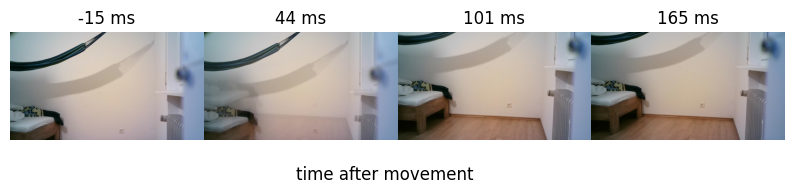

In [69]:
setAngle(math.pi)
time.sleep(0.3)

context = zmq.Context()
sub = context.socket(zmq.SUB)
sub.connect("tcp://localhost:5555") # frame publisher
sub.connect("tcp://localhost:5550") # viewer
sub.setsockopt_string(zmq.SUBSCRIBE, "camera_frame")
sub.setsockopt(zmq.CONFLATE, 1) # take most recent
setAngle(math.pi+0.1)
start = time.time()
data = [get_image() for i in range(4)]

times = [t[0]-start for t in data]
times
images = [t[1] for t in data][:4]

f, ax = plt.subplots(1, len(images), figsize=(10,2))
for a, t, i in zip(ax.flatten(), times, images):
    a.imshow(i[:,:,::-1])
    a.axis("off")
    a.set_title(f"{round(t*1000)} ms")
f.supxlabel("time after movement")
plt.subplots_adjust(wspace=0)
plt.show()

The first 1.5 images after the movement are still at the old position. (With the additional delay of the detection possibly more).